load_images_from_two_folders took 32.49 seconds
load_images_from_two_folders took 26.06 seconds
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       774
           1       0.92      0.98      0.95      1790

    accuracy                           0.92      2564
   macro avg       0.93      0.89      0.90      2564
weighted avg       0.92      0.92      0.92      2564



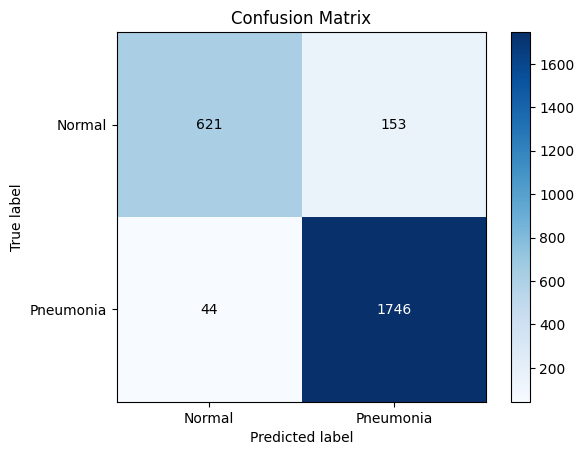

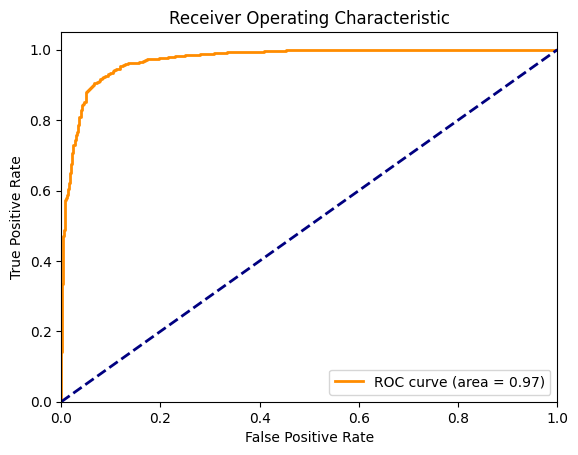

In [2]:
# Import necessary libraries
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import cv2

# Paths to the datasets
path_train_malades = 'C:/Users/Mentu/Documents/IA/Zoidberg/train/PNEUMONIA'
path_train_non_malades = 'C:/Users/Mentu/Documents/IA/Zoidberg/train/NORMAL'
path_test_malades = 'C:/Users/Mentu/Documents/IA/Zoidberg/test/PNEUMONIA'
path_test_non_malades = 'C:/Users/Mentu/Documents/IA/Zoidberg/test/NORMAL'

# Timing function to measure execution time of functions
def timing_function(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start:.2f} seconds")
        return result
    return wrapper 

# Function to load images from two folders
@timing_function
def load_images_from_two_folders(folder1, folder2, image_size=(90, 90)):
    images, labels = [], []

    # Load images from the first folder
    for filename in os.listdir(folder1):
        if filename.endswith('.jpeg'): # Check file extension if necessary
            img = Image.open(os.path.join(folder1, filename)).convert('L')  # Convert to grayscale
            img = crop_lungs_from_image(img)
            img = img.resize(image_size)
            images.append(np.array(img).flatten())  # Flatten the image
            labels.append(1)  # Label 1 for the first folder

    # Load images from the second folder
    for filename in os.listdir(folder2):
        if filename.endswith('.jpeg'):  # Check file extension if necessary
            img = Image.open(os.path.join(folder2, filename)).convert('L')  # Convert to grayscale
            img = crop_lungs_from_image(img)
            img = img.resize(image_size)
            images.append(np.array(img).flatten())  # Flatten the image
            labels.append(0)  # Label 0 for the second folder

    return np.array(images), np.array(labels)

# Function to crop lung area from an image
def crop_lungs_from_image(img):
    """Crops only lungs image from image.
    :param img: image to be cropped.
    :returns: cropped image."""
    img_cv = np.array(img)
    _, thresh = cv2.threshold(img_cv, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_img_cv = img_cv[y:y + h, x:x + w]
    cropped_img = Image.fromarray(cropped_img_cv)
    return cropped_img

# Load training images and labels
train_images, train_labels = load_images_from_two_folders(path_train_malades, path_train_non_malades)

# Load test images and labels
test_images, test_labels = load_images_from_two_folders(path_test_malades, path_test_non_malades)

# Create a pipeline with data scaling and SVM
pipeline = make_pipeline(StandardScaler(), SVC(probability=True, class_weight='balanced', kernel='rbf'))

# Train the model
pipeline.fit(train_images, train_labels)

# Make predictions
predicted_labels = pipeline.predict(test_images)

# Print classification report
print(classification_report(test_labels, predicted_labels))

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Normal', 'Pneumonia'],
       yticklabels=['Normal', 'Pneumonia'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.show()

# Compute ROC curve and ROC area for the test set
probabilities = pipeline.predict_proba(test_images)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
